In [5]:

def khatrirao(matrices, reverse=False):
    # Compute the Khatri-Rao product of all matrices in list "matrices".
    # If reverse is true, does the product in reverse order.
    matorder = range(len(matrices)) if not reverse else list(reversed(range(len(matrices))))
    
    # Error checking on matrices; compute number of rows in result.
    # N = number of columns (must be same for each input)
    N = matrices[0].shape[1] 
    # Compute number of rows in resulting matrix
    # After the loop, M = number of rows in result.
    M = 1
    for i in matorder:
        if matrices[i].ndim != 2:
            raise ValueError("Each argument must be a matrix.")
        if N != (matrices[i].shape)[1]:
            raise ValueError("All matrices must have the same number of columns.")
        M *= (matrices[i].shape)[0]
        
    # Computation
    # Preallocate result.
    P = NP.zeros((M, N))
    
    # n loops over all column indices
    for n in range(N):
        # ab = nth col of first matrix to consider
        ab = matrices[matorder[0]][:,n]
        # loop through matrices
        for i in matorder[1:]:
            # Compute outer product of nth columns
            ab = NP.outer(matrices[i][:,n], ab[:])
        # Fill nth column of P with flattened result
        P[:,n] = ab.flatten()
    return P


def im2double(im):
    info = NP.iinfo(im.dtype) # Get the data type of the input image
    return im.astype(NP.float) / info.max 



In [7]:
def __get_unfolding_mode_order(A, n):
    return [i for i in xrange(n+1, A.ndim)] + [i for i in xrange(n)]
def __get_unfolding_stride(A, mode_order):
    stride = [0 for i in xrange(A.ndim)]
    stride[mode_order[A.ndim-2]] = 1
    for i in xrange(A.ndim-3, -1, -1):
        stride[mode_order[i]] = (
            A.shape[mode_order[i+1]] * stride[mode_order[i+1]])
    return stride
def __get_tensor_indices(r, c, A, n, mode_order, stride):
    i = [0 for j in xrange(A.ndim)]
    i[n] = r
    i[mode_order[0]] = c / stride[mode_order[0]]
    for k in xrange(1, A.ndim-1):
        i[mode_order[k]] = (
            (c % stride[mode_order[k-1]]) / stride[mode_order[k]])
    return i
def get_unfolding_matrix_size(A, n):
    row_count = A.shape[n]    
    col_count = 1   
    for i in xrange(A.ndim):
        if i != n: col_count *= A.shape[i]        
    return (row_count, col_count)
def unfold(A, n):
    """
    Unfold tensor A along Mode n
    """
    (row_count, col_count) = get_unfolding_matrix_size(A, n)
    result = NP.zeros((row_count, col_count))
     
    mode_order = __get_unfolding_mode_order(A, n)
    stride = __get_unfolding_stride(A, mode_order)
         
    for r in xrange(row_count):        
        for c in xrange(col_count):
            i = __get_tensor_indices(r, c, A, n, mode_order, stride)            
            result[r, c] = A.__getitem__(tuple(i))
 
    return result

In [424]:
#"""
# Tensor Completion using IBP Factorization on matrix slice
#"""
import sys
import cPickle as CP

import numpy as NP
import scipy.io as SPIO

from PyIBP import PyIBP as IBP

# IBP parameter (gamma hyperparameters)
(alpha, alpha_a, alpha_b) = (1., 1., 1.)
# Observed data Gaussian noise (Gamma hyperparameters)
(sigma_x, sx_a, sx_b) = (1., 1., 1.)
# Latent feature weight Gaussian noise (Gamma hyperparameters)
(sigma_a, sa_a, sa_b) = (1., 1., 1.)

# Data
from scipy import misc
will = misc.imread("Will-Smith.jpg")
data = will
sample = NP.random.choice([True, False],  data[:,:,0].shape,p=[0.3,0.7])
miss = sample.astype(int)

datar = data[:,:,0]
datag = data[:,:,1]
datab = data[:,:,2]

rfill = NP.zeros(datar.shape)
gfill = NP.zeros(datag.shape)
bfill = NP.zeros(datab.shape)


# IBP parameter (gamma hyperparameters)
(alpha, alpha_a, alpha_b) = (1., 1., 1.)
# Observed data Gaussian noise (Gamma hyperparameters)
(sigma_x, sx_a, sx_b) = (1., 1., 1.)
# Latent feature weight Gaussian noise (Gamma hyperparameters)
(sigma_a, sa_a, sa_b) = (1., 1., 1.)

# Number of full sampling sweeps
numsamp = 10
burn_in = 0

# Center the data
rcdata = IBP.centerData(datar)
gcdata = IBP.centerData(datag)
bcdata = IBP.centerData(datab)


# Initialize the model
r = IBP(rcdata,(alpha,alpha_a,alpha_b),
        (sigma_x, sx_a, sx_b),
        (sigma_a, sa_a, sa_b),
       missing=miss)
g = IBP(gcdata,(alpha,alpha_a,alpha_b),
        (sigma_x, sx_a, sx_b),
        (sigma_a, sa_a, sa_b),
       missing=miss)
b = IBP(bcdata,(alpha,alpha_a,alpha_b),
        (sigma_x, sx_a, sx_b),
        (sigma_a, sa_a, sa_b),
       missing=miss)


# Do inference
for s in range(numsamp):
    # Print current chain state
    r.sampleReport(s)
    r.fullSample()
    g.fullSample()
    b.fullSample()
    if s > burn_in:
        rfill[sample] = rfill[sample] + r.X[sample]
        gfill[sample] = gfill[sample] + g.X[sample]
        bfill[sample] = bfill[sample] + b.X[sample]



iter 0
	K = 9
	alpha = 1.000000
	sigma_x = 1.000000
	sigma_a = 1.000000
iter 1
	K = 9
	alpha = 3.034091
	sigma_x = 30.373719
	sigma_a = 35.832405
iter 2
	K = 10
	alpha = 2.926967
	sigma_x = 32.029706
	sigma_a = 41.190447
iter 3
	K = 10
	alpha = 2.976080
	sigma_x = 31.785689
	sigma_a = 42.483805
iter 4
	K = 10
	alpha = 3.034844
	sigma_x = 31.353836
	sigma_a = 44.401596
iter 5
	K = 10
	alpha = 2.988239
	sigma_x = 31.189957
	sigma_a = 44.963546
iter 6
	K = 10
	alpha = 2.983340
	sigma_x = 31.200769
	sigma_a = 45.038181
iter 7
	K = 10
	alpha = 2.962118
	sigma_x = 31.221079
	sigma_a = 43.998114
iter 8
	K = 10
	alpha = 3.057905
	sigma_x = 31.115291
	sigma_a = 45.751002
iter 9
	K = 10
	alpha = 3.112038
	sigma_x = 30.971573
	sigma_a = 44.741126


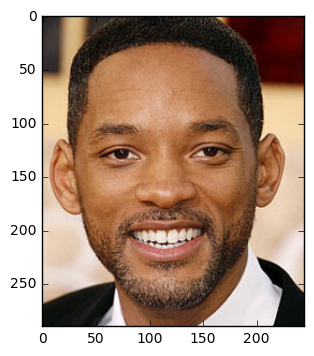

In [133]:
import matplotlib.pyplot as plt
# Real Image
plt.imshow(data)
plt.show()

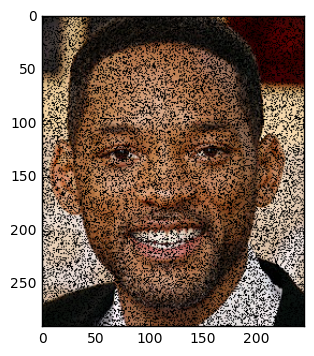

In [134]:
# Incomplete Image
nandata = NP.copy(will)
nandata[:,:,0][sample] = 0
nandata[:,:,1][sample] = 0
nandata[:,:,2][sample] = 0
plt.imshow(nandata)
plt.show()

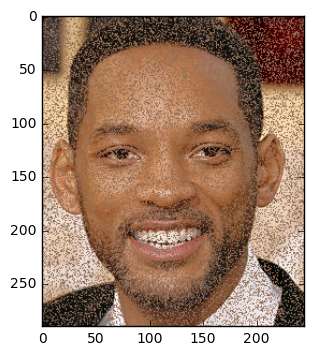

0.0795916247257
0.071017657129
0.0632559173235


In [367]:
# Mean Substitution
olddata = im2double(data)
meandata = im2double(data)
rmean=NP.mean(meandata[:,:,0])
gmean=NP.mean(meandata[:,:,1])
bmean=NP.mean(meandata[:,:,2])
meandata[:,:,0][sample] = rmean
meandata[:,:,1][sample] = gmean
meandata[:,:,2][sample] = bmean
plt.imshow(meandata)
plt.show()
print(NP.mean((olddata[:,:,0][sample]-rmean)**2))
print(NP.mean((olddata[:,:,1][sample]-gmean)**2))
print(NP.mean((olddata[:,:,2][sample]-bmean)**2))

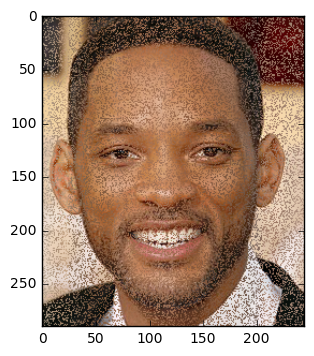

0.0741458353875
0.0649683939239
0.056720769211


In [135]:
# Column Mean Substitution
meandata = im2double(data)
olddata = im2double(data)
for i in range(will.shape[1]):
    rmean=NP.mean(meandata[:,i,0])
    gmean=NP.mean(meandata[:,i,1])
    bmean=NP.mean(meandata[:,i,2])
    meandata[:,i,0][sample[:,i]] = rmean
    meandata[:,i,1][sample[:,i]] = gmean
    meandata[:,i,2][sample[:,i]] = bmean
plt.imshow(meandata)
plt.show()
print(NP.mean((olddata[:,:,0][sample]-meandata[:,:,0][sample])**2))
print(NP.mean((olddata[:,:,1][sample]-meandata[:,:,1][sample])**2))
print(NP.mean((olddata[:,:,2][sample]-meandata[:,:,2][sample])**2))

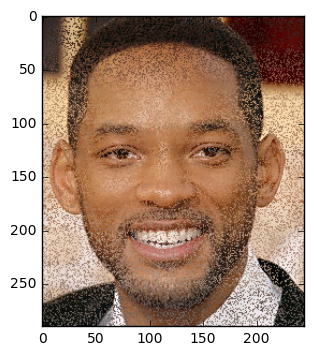

0.054903312897
0.0541459485192
0.0513219861633


In [370]:
# Row Mean Substitution
meandata = im2double(data)
olddata = im2double(data)
for i in range(will.shape[0]):
    rmean=NP.mean(meandata[i,:,0])
    gmean=NP.mean(meandata[i,:,1])
    bmean=NP.mean(meandata[i,:,2])
    meandata[i,:,0][sample[i,:]] = rmean
    meandata[i,:,1][sample[i,:]] = gmean
    meandata[i,:,2][sample[i,:]] = bmean
plt.imshow(meandata)
plt.show()
print(NP.mean((olddata[:,:,0][sample]-meandata[:,:,0][sample])**2))
print(NP.mean((olddata[:,:,1][sample]-meandata[:,:,1][sample])**2))
print(NP.mean((olddata[:,:,2][sample]-meandata[:,:,2][sample])**2))

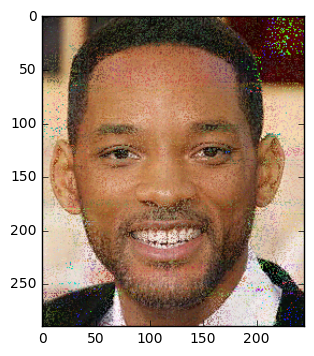

0.022576205848
0.0348134940287
0.0265433088455


In [136]:
# Completed Image
completed = NP.copy(data)
olddata = im2double(data)
completed[:,:,0][sample] = r.featMeans(datar)[sample] + rfill[sample]/(numsamp - burn_in) 
completed[:,:,1][sample] = g.featMeans(datag)[sample] + gfill[sample]/(numsamp - burn_in) 
completed[:,:,2][sample] = b.featMeans(datab)[sample] + bfill[sample]/(numsamp - burn_in) 
completed = im2double(completed)
plt.imshow(completed)
plt.show()
print(NP.mean((olddata[:,:,0][sample]-completed[:,:,0][sample])**2))
print(NP.mean((olddata[:,:,1][sample]-completed[:,:,1][sample])**2))
print(NP.mean((olddata[:,:,2][sample]-completed[:,:,2][sample])**2))

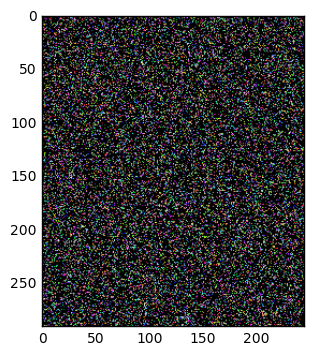

In [324]:
# The fill-ins seem random when stacked... But separated yield approximations to the image
completed = NP.zeros(data.shape)
completed[:,:,0][sample] = rfill[sample]/(numsamp - burn_in) 
completed[:,:,1][sample] = gfill[sample]/(numsamp - burn_in) 
completed[:,:,2][sample] = bfill[sample]/(numsamp - burn_in) 
plt.imshow(completed)
plt.show()

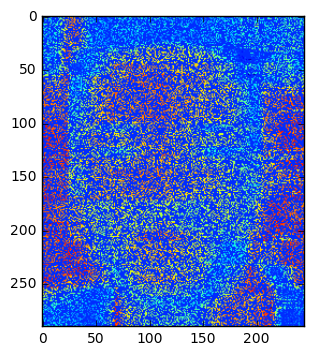

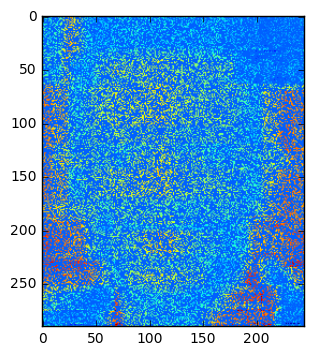

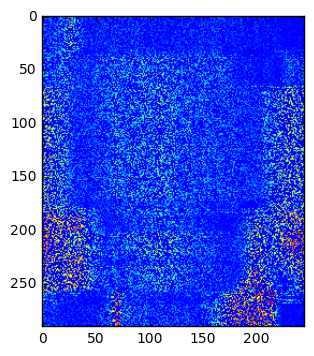

In [325]:
# The fillins seem random when stacked... But separated yield approximations to the image
completed = NP.zeros((data.shape))
completed[:,:,0][sample] = r.featMeans(datar)[sample] + rfill[sample]/(numsamp - burn_in) 
completed[:,:,1][sample] = g.featMeans(datag)[sample] + gfill[sample]/(numsamp - burn_in) 
completed[:,:,2][sample] = b.featMeans(datab)[sample] + bfill[sample]/(numsamp - burn_in) 
plt.imshow(completed[:,:,0])
plt.show()
plt.imshow(completed[:,:,1])
plt.show()
plt.imshow(completed[:,:,2])
plt.show()

In [12]:
import sktensor as t
import sys
import cPickle as CP

import numpy as NP
import scipy.io as SPIO

from PyIBP import PyIBP as IBP

will = misc.imread("Will-Smith.jpg")
data = will
sample = NP.random.choice([True, False],  data[:,:,1].shape,p=[0.3,0.7])
miss = sample.astype(int)

tensorsample = NP.zeros(data.shape)
for i in range(data.shape[2]):
    tensorsample[:,:,i] = sample
    
T = t.dtensor(data)
S = t.dtensor(tensorsample)

X1miss = S.unfold(0).astype(bool)
X2miss = S.unfold(1).astype(bool)
X3miss = S.unfold(2).astype(bool)

X1dat = T.unfold(0)
X2dat = T.unfold(1)
X3dat = T.unfold(2)

X1fill = NP.zeros(X1dat.shape)
X2fill = NP.zeros(X2dat.shape)
X3fill = NP.zeros(X3dat.shape)

# Number of full sampling sweeps
numsamp = 5
burn_in = 0

X1cdat = IBP.centerData(X1dat)
X2cdat = IBP.centerData(X2dat)
X3cdat = IBP.centerData(X3dat)

# Initialize the model
X1 = IBP(X1cdat,(alpha,alpha_a,alpha_b),
        (sigma_x, sx_a, sx_b),
        (sigma_a, sa_a, sa_b),
       missing=X1miss.astype(int))
X2 = IBP(X2cdat,(alpha,alpha_a,alpha_b),
        (sigma_x, sx_a, sx_b),
        (sigma_a, sa_a, sa_b),
       missing=X2miss.astype(int))
X3 = IBP(X3cdat,(alpha,alpha_a,alpha_b),
        (sigma_x, sx_a, sx_b),
        (sigma_a, sa_a, sa_b),
       missing=X3miss.astype(int))


# Do inference
for s in range(numsamp):
# Print current chain state
    X3.sampleReport(s)
    X1.fullSample()
    X2.fullSample()
    X3.fullSample()
    if s > burn_in:
        X1fill[X1miss] = X1fill[X1miss] + X1.X[X1miss]
        X2fill[X2miss] = X2fill[X2miss] + X2.X[X2miss]
        X3fill[X3miss] = X3fill[X3miss] + X3.X[X3miss]



iter 0
	K = 2
	alpha = 1.000000
	sigma_x = 1.000000
	sigma_a = 1.000000
iter 1
	K = 2
	alpha = 1.228041
	sigma_x = 12.783993
	sigma_a = 15.073206
iter 2
	K = 2
	alpha = 0.558145
	sigma_x = 14.553017
	sigma_a = 20.997238
iter 3
	K = 2
	alpha = 0.697547
	sigma_x = 14.400873
	sigma_a = 25.423268
iter 4
	K = 2
	alpha = 0.541690
	sigma_x = 13.521866
	sigma_a = 28.752949


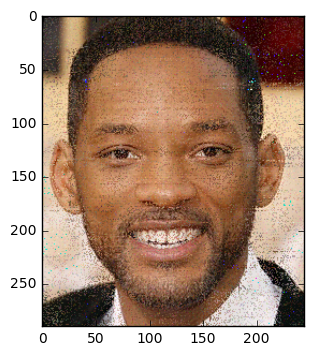

0.0251715247058
0.0818262689288
(213150, 51250)


In [543]:
# Completed X1 Matrix
NewX1 = T.unfold(0)
OldX1 = im2double(X1dat)
NewX1[X1miss] = X1.featMeans(X1dat)[X1miss] + X1fill[X1miss]/(numsamp - burn_in)
NewX1 = im2double(NewX1)
plt.imshow(NewX1.fold())
plt.show()
mean = NP.mean(NewX1)
print(NP.mean((OldX1[X1miss]-NewX1[X1miss])**2))
print(NP.mean((OldX1[X1miss]-mean)**2))
print((X1.X.size, (numsamp-burn_in)*(X1.ZV.size + X1.weights().size)))

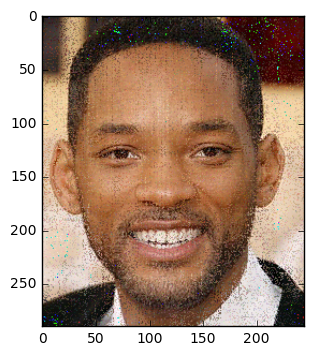

0.025324584716
0.0818286065765
(213150, 55750)


In [542]:
# Completed X2 Matrix
NewX2 = T.unfold(1)
OldX2 = im2double(X2dat)
NewX2[X2miss] = X2.featMeans(X2dat)[X2miss] + X2fill[X2miss]/(numsamp - burn_in) 
NewX2= im2double(NewX2)
mean = NP.mean(NewX2)
plt.imshow(NewX2.fold())
plt.show()
print(NP.mean((OldX2[X2miss]-NewX2[X2miss])**2))
print(NP.mean((OldX2[X2miss]-mean)**2))
print((X2.X.size, (numsamp-burn_in)*(X2.ZV.size + X2.weights().size)))

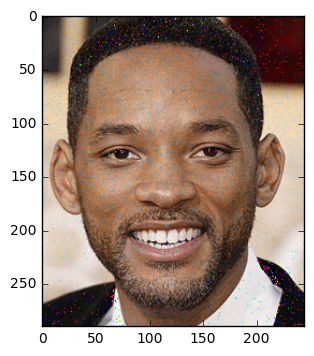

0.0233912383061
0.0818339967485
(213150, 1065795)


In [541]:
# Completed X3 Matrix
NewX3 = T.unfold(2)
OldX3 = im2double(X3dat)
NewX3[X3miss] = X3.featMeans(X3dat)[X3miss] + X3fill[X3miss]/(numsamp - burn_in) 
NewX3= im2double(NewX3)
mean = NP.mean(NewX3)
plt.imshow(NewX3.fold())
plt.show()
print(NP.mean((OldX3[X3miss]-NewX3[X3miss])**2))
print(NP.mean((OldX3[X3miss]-mean)**2))
print((X3.X.size, (numsamp-burn_in)*(X3.ZV.size + X3.weights().size)))

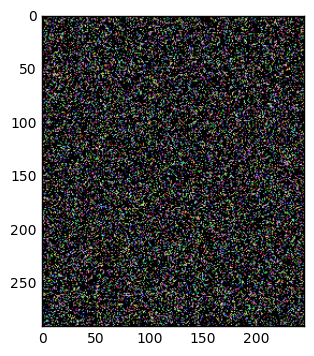

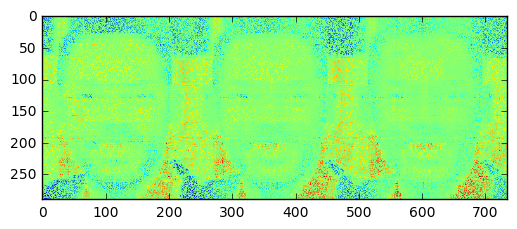

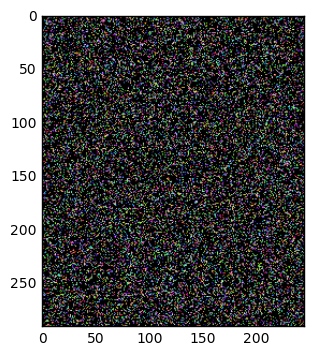

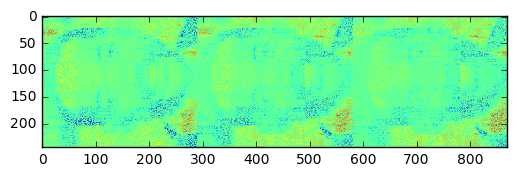

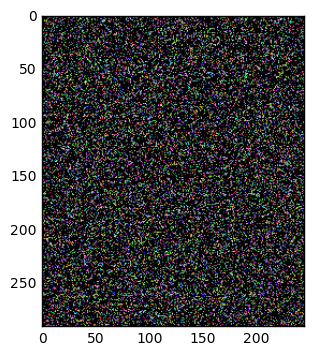

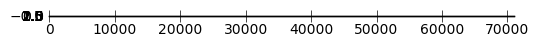

In [627]:
ZT = t.dtensor(NP.zeros(data.shape))

NewX1 = ZT.unfold(0)
NewX2 = ZT.unfold(1)
NewX3 = ZT.unfold(2)

NewX1[X1miss] = X1fill[X1miss]/(numsamp - burn_in) 
NewX2[X2miss] = X2fill[X2miss]/(numsamp - burn_in) 
NewX3[X3miss] = X3fill[X3miss]/(numsamp - burn_in)

plt.imshow(NewX1.fold())
plt.show()
plt.imshow(NewX1)
plt.show()
plt.imshow(NewX2.fold())
plt.show()
plt.imshow(NewX2)
plt.show()
plt.imshow(NewX3.fold())
plt.show()
plt.imshow(NewX3)
plt.show()

In [ ]:
import sktensor as t
import sys
import cPickle as CP

import numpy as NP
import scipy.io as SPIO

from PyIBP import PyIBP as IBP

will = misc.imread("Will-Smith.jpg")
data = will
sample = NP.random.choice([True, False],  data[:,:,1].shape,p=[0.3,0.7])
miss = sample.astype(int)

tensorsample = NP.zeros(data.shape)
for i in range(data.shape[2]):
    tensorsample[:,:,i] = sample
    
T = t.dtensor(data)
S = t.dtensor(tensorsample)

X1miss = S.unfold(0).astype(bool)
X2miss = S.unfold(1).astype(bool)
X3miss = S.unfold(2).astype(bool)

X1dat = T.unfold(0)
X2dat = T.unfold(1)
X3dat = T.unfold(2)

X1fill = NP.zeros(X1dat.shape)
X2fill = NP.zeros(X2dat.shape)
X3fill = NP.zeros(X3dat.shape)

# Number of full sampling sweeps
numsamp = 5
burn_in = 0

X1cdat = IBP.centerData(X1dat)
X2cdat = IBP.centerData(X2dat)
X3cdat = IBP.centerData(X3dat)

# Initialize the model
X1 = IBP(X1cdat,(alpha,alpha_a,alpha_b),
        (sigma_x, sx_a, sx_b),
        (sigma_a, sa_a, sa_b),
       missing=X1miss.astype(int))
X2 = IBP(X2cdat,(alpha,alpha_a,alpha_b),
        (sigma_x, sx_a, sx_b),
        (sigma_a, sa_a, sa_b),
       missing=X2miss.astype(int))
X3 = IBP(X3cdat,(alpha,alpha_a,alpha_b),
        (sigma_x, sx_a, sx_b),
        (sigma_a, sa_a, sa_b),
       missing=X3miss.astype(int))


# Do inference
for s in range(numsamp):
# Print current chain state
    X3.sampleReport(s)
    X1.fullSample()
    X2.fullSample()
    X3.fullSample()
    if s > burn_in:
        X1fill[X1miss] = X1fill[X1miss] + X1.X[X1miss]
        X2fill[X2miss] = X2fill[X2miss] + X2.X[X2miss]
        X3fill[X3miss] = X3fill[X3miss] + X3.X[X3miss]



In [20]:
N = 5
I = 30
J = 30
K = 40
A = NP.random.randint(-2,3,(30,5))
B = NP.random.randint(-2,3,(30,5))
C = NP.random.randint(-2,3,(40,5))

F = NP.zeros((30,30,40))
for n in range(N):
        for i in range(30):
                for j in range(30):
                    for k in range(40):
                        F[i,j,k] = F[i,j,k] + A[i,n]*B[j,n]*C[k,n] + NP.random.normal(0,5)

In [22]:
data = F
sample = NP.random.choice([True, False],  data.shape,p=[0.3,0.7])

T = t.dtensor(data)
S = t.dtensor(sample)

X1miss = S.unfold(0).astype(bool)
X2miss = S.unfold(1).astype(bool)
X3miss = S.unfold(2).astype(bool)

X1dat = T.unfold(0)
X2dat = T.unfold(1)
X3dat = T.unfold(2)


In [149]:

X1fill = NP.zeros(X1dat.shape)
X2fill = NP.zeros(X2dat.shape)
X3fill = NP.zeros(X3dat.shape)

# Number of full sampling sweeps
numsamp = 35
burn_in = 30

X1cdat = IBP.centerData(X1dat)
X2cdat = IBP.centerData(X2dat)
X3cdat = IBP.centerData(X3dat)

# Initialize the model
X1 = IBP(X1cdat,(alpha,alpha_a,alpha_b),
        (sigma_x, sx_a, sx_b),
        (sigma_a, sa_a, sa_b),
       missing=X1miss.astype(int))
X2 = IBP(X2cdat,(alpha,alpha_a,alpha_b),
        (sigma_x, sx_a, sx_b),
        (sigma_a, sa_a, sa_b),
       missing=X2miss.astype(int))
X3 = IBP(X3cdat,(alpha,alpha_a,alpha_b),
        (sigma_x, sx_a, sx_b),
        (sigma_a, sa_a, sa_b),
       missing=X3miss.astype(int))


# Do inference
for s in range(numsamp):
# Print current chain state
    X3.sampleReport(s)
    X1.fullSample()
    X2.fullSample()
    X3.fullSample()
    if s > burn_in:
        X1fill[X1miss] = X1fill[X1miss] + X1.X[X1miss]
        X2fill[X2miss] = X2fill[X2miss] + X2.X[X2miss]
        X3fill[X3miss] = X3fill[X3miss] + X3.X[X3miss]



iter 0
	K = 5
	alpha = 1.000000
	sigma_x = 1.000000
	sigma_a = 1.000000
iter 1
	K = 5
	alpha = 2.403263
	sigma_x = 9.150120
	sigma_a = 4.718963
iter 2
	K = 7
	alpha = 2.093867
	sigma_x = 10.643823
	sigma_a = 4.648605
iter 3
	K = 7
	alpha = 2.435552
	sigma_x = 11.239292
	sigma_a = 4.463837
iter 4
	K = 7
	alpha = 2.018544
	sigma_x = 11.499058
	sigma_a = 4.313745
iter 5
	K = 8
	alpha = 1.763786
	sigma_x = 11.635600
	sigma_a = 4.241709
iter 6
	K = 9
	alpha = 1.729980
	sigma_x = 11.527484
	sigma_a = 4.125609
iter 7
	K = 10
	alpha = 1.729757
	sigma_x = 11.592336
	sigma_a = 4.036985
iter 8
	K = 9
	alpha = 2.418226
	sigma_x = 11.639300
	sigma_a = 4.019738
iter 9
	K = 9
	alpha = 2.158078
	sigma_x = 11.665462
	sigma_a = 3.928872
iter 10
	K = 10
	alpha = 2.053850
	sigma_x = 11.492304
	sigma_a = 3.851675
iter 11
	K = 11
	alpha = 2.115454
	sigma_x = 11.538189
	sigma_a = 3.835263
iter 12
	K = 12
	alpha = 1.728981
	sigma_x = 11.443857
	sigma_a = 3.780688
iter 13
	K = 12
	alpha = 2.092469
	sigma_x = 1

KeyboardInterrupt: 

In [25]:
# Completed X1 Matrix
NewX1 = T.unfold(0)
OldX1 = NP.copy(X1cdat)
NewX1[X1miss] = X1fill[X1miss]/(numsamp - burn_in)
mean = NP.mean(OldX1)
print(NP.mean((OldX1[X1miss]-NewX1[X1miss])**2))
print(NP.mean((OldX1[X1miss]-mean)**2))
print((X1.X.size, (numsamp-burn_in)*(X1.ZV.size + X1.weights().size)))

142.644679265
159.157656387
(36000, 418200)


In [26]:
# Completed X2 Matrix
NewX2 = T.unfold(1)
OldX2 = NP.copy(X2cdat)
NewX2[X2miss] = X2fill[X2miss]/(numsamp - burn_in) 
mean = NP.mean(OldX2)
print(NP.mean((OldX2[X2miss]-NewX2[X2miss])**2))
print(NP.mean((OldX2[X2miss]-mean)**2))
print((X2.X.size, (numsamp-burn_in)*(X2.ZV.size + X2.weights().size)))

146.912634197
160.127206586
(36000, 369000)


In [27]:
# Completed X3 Matrix
NewX3 = T.unfold(2)
OldX3 = NP.copy(X3cdat)
NewX3[X3miss] = X3fill[X3miss]/(numsamp - burn_in) 
mean = NP.mean(OldX3)
print(NP.mean((OldX3[X3miss]-NewX3[X3miss])**2))
print(NP.mean((OldX3[X3miss]-mean)**2))
print((X3.X.size, (numsamp-burn_in)*(X3.ZV.size + X3.weights().size)))

141.010559622
160.315066113
(36000, 300800)


In [320]:
import sktensor as t
import sys
import cPickle as CP

import numpy as NP
import scipy.io as SPIO

from PyIBP import PyIBP as IBP

will = misc.imread("Will-Smith.jpg")
data = will
sample = NP.random.choice([True, False],  data[:,:,1].shape,p=[0.3,0.7])
miss = sample.astype(int)

tensorsample = NP.zeros(data.shape)
for i in range(data.shape[2]):
    tensorsample[:,:,i] = sample
    
T = t.dtensor(data)
S = t.dtensor(tensorsample)

X1miss = S.unfold(0).astype(bool)
X2miss = S.unfold(1).astype(bool)
X3miss = S.unfold(2).astype(bool)

X1dat = T.unfold(0)
X2dat = T.unfold(1)
X3dat = T.unfold(2)

X1fill = NP.zeros(X1dat.shape)
X2fill = NP.zeros(X2dat.shape)
X3fill = NP.zeros(X3dat.shape)

# Number of full sampling sweeps
numsamp = 20
burn_in = 10

X1cdat = IBP.centerData(X1dat)
X2cdat = IBP.centerData(X2dat)
X3cdat = IBP.centerData(X3dat)

# Initialize the model
X1 = IBP(X1cdat,(alpha,alpha_a,alpha_b),
        (sigma_x, sx_a, sx_b),
        (sigma_a, sa_a, sa_b),
       missing=X1miss.astype(int))


# Do inference
for s in range(numsamp):
# Print current chain state
    print s
    X1.fullSample()
    if s > burn_in:
        X1fill[X1miss] = X1fill[X1miss] + X1.X[X1miss]
   
temp = X1.X
temp[X1miss] = X1fill[X1miss]/(numsamp-burn_in)

X2 = IBP(temp.fold().unfold(1),(alpha,alpha_a,alpha_b),
        (sigma_x, sx_a, sx_b),
        (sigma_a, sa_a, sa_b),
        missing=X2miss.astype(int))

for s in range(numsamp):
# Print current chain state
    print s
    X2.fullSample()
    if s > burn_in:
        X2fill[X2miss] = X2fill[X2miss] + X2.X[X2miss]

temp = X2.X
temp[X2miss] = X2fill[X2miss]/(numsamp-burn_in)
        
X3 = IBP(temp.fold().unfold(2),(alpha,alpha_a,alpha_b),
        (sigma_x, sx_a, sx_b),
        (sigma_a, sa_a, sa_b),
        missing=X3miss.astype(int))

for s in range(numsamp):
# Print current chain state
    print s
    X3.fullSample()
    if s > burn_in:
        X3fill[X3miss] = X3fill[X3miss] + X3.X[X3miss]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


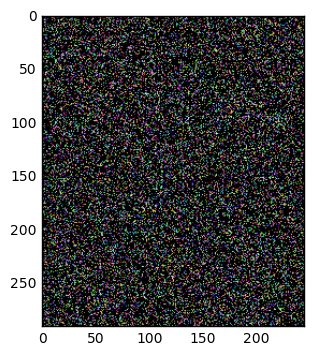

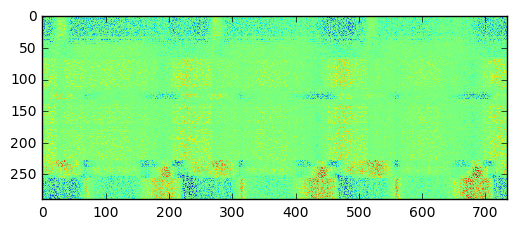

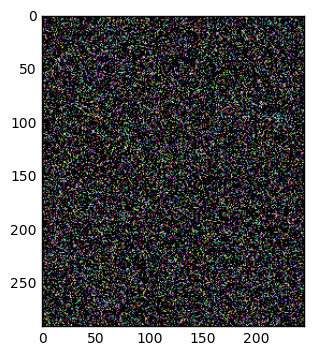

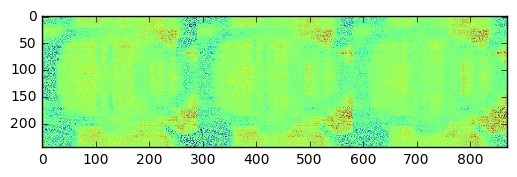

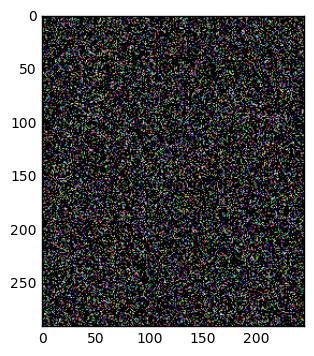

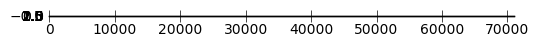

In [321]:
ZT = t.dtensor(NP.zeros(data.shape))

NewX1 = ZT.unfold(0)
NewX2 = ZT.unfold(1)
NewX3 = ZT.unfold(2)

NewX1[X1miss] = X1fill[X1miss]/(numsamp - burn_in) 
NewX2[X2miss] = X2fill[X2miss]/(numsamp - burn_in) 
NewX3[X3miss] = X3fill[X3miss]/(numsamp - burn_in)

plt.imshow(NewX1.fold())
plt.show()
plt.imshow(NewX1)
plt.show()
plt.imshow(NewX2.fold())
plt.show()
plt.imshow(NewX2)
plt.show()
plt.imshow(NewX3.fold())
plt.show()
plt.imshow(NewX3)
plt.show()

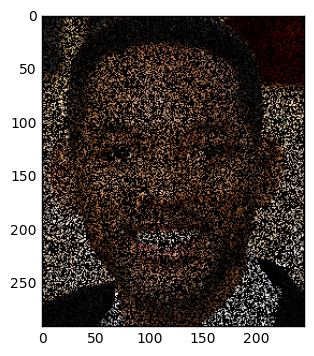

In [316]:
will = misc.imread("Will-Smith.jpg")
temp = NP.zeros((290,245,3))
temp[tensorsample.astype(bool)] = im2double(will)[tensorsample.astype(bool)]
plt.imshow(temp[:,:,:])
plt.show()

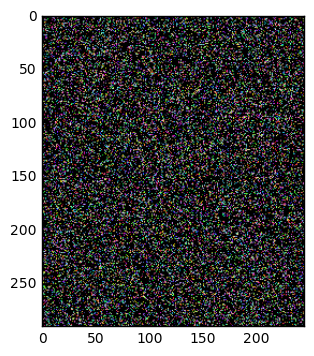

In [322]:
ZT = t.dtensor(NP.zeros(data.shape))

NewX1 = ZT.unfold(0)
NewX2 = ZT.unfold(1)
NewX3 = ZT.unfold(2)

NewX1[X1miss] = X1fill[X1miss]/(numsamp - burn_in) 
NewX2[X2miss] = X2fill[X2miss]/(numsamp - burn_in) 
NewX3[X3miss] = X3fill[X3miss]/(numsamp - burn_in)

plt.imshow(NewX1.fold()/3 + NewX2.fold()/3 + NewX3.fold()/3)
plt.show()

In [421]:
A = NP.array([[1,2,3],[4,5,6],[7,8,9]])
B = NP.array([[1,0,0],[0,1,0],[0,0,1]])

In [461]:
def outer(A,B,C):
    N = A.shape[1]
    I = A.shape[0]
    J = B.shape[0]
    K = C.shape[0]
    temp = NP.zeros((I,J,K))
    for n in range(N):
        a = A[:,n]
        b = B[:,n]
        c = C[:,n]
        temp += (a[:,None]*b)[:,:,None]*c
    return temp

In [435]:
def outer2(A,B):
    N = A.shape[1]
    I = A.shape[0]
    J = B.shape[0]
    temp = NP.zeros((I,J))
    for n in range(N):
        a = A[:,n]
        b = B[:,n]
        temp += (a[:,None]*b)
    return temp

In [433]:
r.weights().T.shape

(245, 10)

In [556]:
import sktensor as t
import sys
import cPickle as CP

import numpy as NP
import scipy.io as SPIO

from PyIBP import PyIBP as IBP

will = misc.imread("Will-Smith.jpg")
data = will
sample = NP.random.choice([True, False],  data[:,:,1].shape,p=[0.3,0.7])
miss = sample.astype(int)

tensorsample = NP.zeros(data.shape)
for i in range(data.shape[2]):
    tensorsample[:,:,i] = sample
    
T = t.dtensor(data)
S = t.dtensor(tensorsample)

X1miss = S.unfold(0).astype(bool)
X2miss = S.unfold(1).astype(bool)
X3miss = S.unfold(2).astype(bool)

X1dat = T.unfold(0)
X2dat = T.unfold(1)
X3dat = T.unfold(2)

X1fill = NP.zeros(X1dat.shape)
X2fill = NP.zeros(X2dat.shape)
X3fill = NP.zeros(X3dat.shape)

# Number of full sampling sweeps
numsamp = 20
burn_in = 10

X1cdat = IBP.centerData(X1dat)
X2cdat = IBP.centerData(X2dat)
X3cdat = IBP.centerData(X3dat)

# Initialize the model
X1 = IBP(X1cdat,(alpha,alpha_a,alpha_b),
        (sigma_x, sx_a, sx_b),
        (sigma_a, sa_a, sa_b),
       missing=X1miss.astype(int))


# Do inference
for s in range(numsamp):
# Print current chain state
    print s
    X1.fullSample()
    if s > burn_in:
        X1fill[X1miss] = X1fill[X1miss] + X1.X[X1miss]


0
1


KeyboardInterrupt: 

In [521]:
T.shape

(290, 245, 3)

In [529]:
cp = t.cp.als(T,3)

In [567]:
asd = X1.weights()
dsa = t.unfolded_dtensor(asd,1,(12,245,3))
dsa.fold().shape

(12, 245, 3)

In [572]:
X2.weights().shape

(12, 870)

In [573]:
X1.weights().shape

(12, 735)

In [585]:
NP.kron(Xd

MemoryError: 